# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd

%matplotlib inline
from matplotlib import pyplot as plt
import os.path as osp

In [2]:
net = build_ssd('test', 300, 2)    # initialize SSD
net.load_weights('../weights/dehaze/ssd300_dehaze_1_1e-5_11500.pth')

Loading weights into state dict...
Finished!


/home/jovyan/ssd/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)


# 计算gt和pt的iou

In [3]:
#计算iou
def get_iou(gt, pt):
    x_left = max(gt[0],pt[0])
    y_top = max(gt[1], pt[1])
    x_right = min(gt[2], pt[2])
    y_bottom = min(gt[3], pt[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    bb1_area = (gt[2] - gt[0]) * (gt[3] - gt[1])
    bb2_area = (pt[2] - pt[0]) * (pt[3] - pt[1])
    
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

# 计算gts和pts的指标

In [4]:
#计算该图像的num p tp fp rpp  
def calculate(gts,pts,iou_limit=0.5):
    gt_labels = np.zeros(len(gts))
    pt_labels = np.zeros(len(pts))
    tp = 0
    fp = 0
    fn = 0
    rpp = 0 #多个预测一个猪场
    rpp2 = 0#一个预测多个猪场
    
    
    for j,pt in enumerate(pts):
        for i,gt in enumerate(gts):
            iou = get_iou(gt,pt)
            if iou >= iou_limit:
                if gt_labels[i]==0 and pt_labels[j]==0:
                    tp += 1
                elif gt_labels[i]==1 and pt_labels[j]==0:
                    tp += 1
                    rpp += 1
                elif gt_labels[i]==0 and pt_labels[j]==1:
                    tp += 1
                    rpp2 += 1
                else:
                    print('error')
                gt_labels[i] = 1
                pt_labels[j] = 1
        if pt_labels[j] == 0:
            fp += 1
    for j,gt in enumerate(gts):
        if gt_labels[j] == 0:
            fn += 1
    return [tp, fp, fn]

In [5]:
def eval(limit_detection,dataset,iou_limit,predict_multi=0):
    sum_of_pigfarms = 0
    sum_of_predict_pigfarms = 0
    sum_of_tp = 0
    sum_of_fp = 0
    sum_of_fn = 0
    
    testset = VOCDetection(VOC_ROOT, [('2007', dataset)], None, VOCAnnotationTransform())
    for img_id in range(len(testset)):
#         if img_id%100==0:
#             print(img_id,'/',len(testset))
        image = testset.pull_image(img_id)

        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        x = cv2.resize(image, (300, 300)).astype(np.float32)
        x -= (104.0, 117.0, 123.0)
        x = x.astype(np.float32)
        x = x[:, :, ::-1].copy()
    #     plt.imshow(x)
        x = torch.from_numpy(x).permute(2, 0, 1)

        xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
        if torch.cuda.is_available():
            xx = xx.cuda()
        y = net(xx)


        from data import VOC_CLASSES as labels
        top_k=10

        detections = y.data
        # scale each detection back up to the image
        scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
        
        num = 0
        [imageid, gts] = testset.pull_anno(img_id)
        pts = []
        for i in range(detections.size(1)):
            j = 0
            if predict_multi==0:
                while detections[0,i,j,0] >= limit_detection:
                    score = detections[0,i,j,0]
                    num +=1  
                    pt = (detections[0,i,j,1:]*scale).cpu().numpy()
                    pts.append(pt)
                    j+=1
            else:
                scores = []
                while detections[0,i,j,0]>=0.15:
                    score = detections[0,i,j,0]
                    pt = (detections[0,i,j,1:]*scale).cpu().numpy()

                    if len(pts)<predict_multi*len(gts):
                        pts.append(pt)
                        scores.append(score)
                    else :
                        if score > min(scores):
                            min_index = scores.index(min(scores))
                            pts[min_index] = pt
                            scores[min_index] = score
                    j+=1
                num = len(pts)
#                 if num!=predict_multi*len(gts):
#                     print('error',num,len(gts))
                        
        sum_of_predict_pigfarms += num  #计算预测的猪场的总数
        sum_of_pigfarms += len(gts)  #计算猪场数目

        #根据gts和pts计算该图像的预测参数
        [tp,fp,fn] = calculate(gts,pts,iou_limit)
        
#         print("img ",img_id,': ',tp, fp , rpp)
        sum_of_tp += tp
        sum_of_fp += fp
        sum_of_fn += fn
    return [sum_of_tp,sum_of_fp,sum_of_fn]
#     print("猪场数目：",sum_of_pigfarms)
#     print("预测的猪场数目：",sum_of_predict_pigfarms)
#     print("正确预测的猪场数目",sum_of_tp)
#     print("错误预测的猪场数目",sum_of_fp)
#     print("多个预测一个猪场数目",sum_of_rpp)
#     print("一个预测多个猪场数目",sum_of_rpp2)
#     print("预测准确度 {}/{}={}".format(sum_of_tp-sum_of_rpp+sum_of_rpp2,sum_of_predict_pigfarms-sum_of_rpp+sum_of_rpp2,(sum_of_tp-sum_of_rpp+sum_of_rpp2)/(sum_of_predict_pigfarms-sum_of_rpp+sum_of_rpp2)))
#     print("预测准确数量在猪场数量占比{}/{}={}".format(sum_of_tp,sum_of_pigfarms,sum_of_tp/sum_of_pigfarms))

In [6]:
#是否使用新地图，是则取消第二行注释
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
# VOC_ROOT = osp.join("/home/jovyan/data/newdata/")
VOC_ROOT = osp.join("/home/jovyan/data/data3-5/dehaze/")

# IoU0.5

In [10]:
iou_limit = 0.5
accuracys = []
recalls = []
precisions = []
for score in np.arange(0.1,1.0,0.1):
    print("score:",score)
    dataset = 'test'
    [tp,fp,fn] = eval(score,dataset,iou_limit)

    print("tp：",tp,"fp：",fp,"fn：",fn)
    print("accuracy：",tp/(tp+fp+fn))
    print("recall：",tp/(tp+fn))
    print("precision：",tp/(tp+fp))
    print("----------------------------------------")
    accuracys.append(tp/(tp+fp+fn))
    recalls.append(tp/(tp+fn))
    precisions.append(tp/(tp+fp))

score: 0.1
tp： 603 fp： 6385 fn： 440
accuracy： 0.08117932148626818
recall： 0.5781399808245445
precision： 0.08629078420148827
----------------------------------------
score: 0.2
tp： 461 fp： 733 fn： 553
accuracy： 0.2638809387521465
recall： 0.4546351084812623
precision： 0.3860971524288107
----------------------------------------
score: 0.3
tp： 388 fp： 367 fn： 622
accuracy： 0.28177196804647786
recall： 0.38415841584158417
precision： 0.5139072847682119
----------------------------------------
score: 0.4
tp： 350 fp： 248 fn： 658
accuracy： 0.2786624203821656
recall： 0.3472222222222222
precision： 0.5852842809364549
----------------------------------------
score: 0.5
tp： 308 fp： 181 fn： 700
accuracy： 0.2590412111017662
recall： 0.3055555555555556
precision： 0.6298568507157464
----------------------------------------
score: 0.6
tp： 272 fp： 137 fn： 736
accuracy： 0.23755458515283842
recall： 0.2698412698412698
precision： 0.6650366748166259
----------------------------------------
score: 0.7
tp： 243 fp：

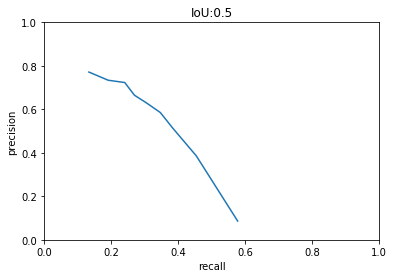

In [15]:
plt.plot(recalls,precisions)
plt.title('IoU:0.5')
plt.xlabel('recall')
plt.ylabel('precision')
plt.axis([0,1,0,1])
plt.show()

# IoU0.3

In [8]:
iou_limit = 0.3
accuracys_2 = []
recalls_2 = []
precisions_2 = []
for score in np.arange(0.1,1.0,0.1):
    print("score:",score)
    dataset = 'test'
    [tp,fp,fn] = eval(score,dataset,iou_limit)

    print("tp：",tp,"fp：",fp,"fn：",fn)
    print("accuracy：",tp/(tp+fp+fn))
    print("recall：",tp/(tp+fn))
    print("precision：",tp/(tp+fp))
    print("----------------------------------------")
    accuracys_2.append(tp/(tp+fp+fn))
    recalls_2.append(tp/(tp+fn))
    precisions_2.append(tp/(tp+fp))

score: 0.1
tp： 935 fp： 6053 fn： 295
accuracy： 0.12838116160922697
recall： 0.7601626016260162
precision： 0.13380080137378364
----------------------------------------
score: 0.2
tp： 594 fp： 600 fn： 452
accuracy： 0.36087484811664644
recall： 0.5678776290630975
precision： 0.49748743718592964
----------------------------------------
score: 0.3
tp： 476 fp： 279 fn： 544
accuracy： 0.36643571978444955
recall： 0.4666666666666667
precision： 0.6304635761589404
----------------------------------------
score: 0.4
tp： 421 fp： 177 fn： 593
accuracy： 0.3534844668345928
recall： 0.4151873767258383
precision： 0.7040133779264214
----------------------------------------
score: 0.5
tp： 365 fp： 124 fn： 644
accuracy： 0.32215357458075905
recall： 0.36174430128840435
precision： 0.7464212678936605
----------------------------------------
score: 0.6
tp： 319 fp： 90 fn： 690
accuracy： 0.2902638762511374
recall： 0.31615460852329036
precision： 0.7799511002444988
----------------------------------------
score: 0.7
tp： 281 f

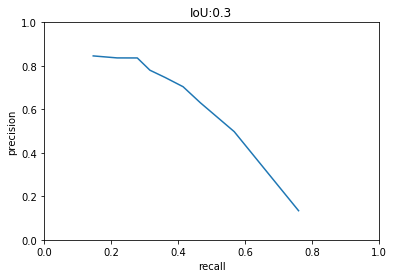

In [16]:
plt.plot(recalls_2,precisions_2)
plt.title("IoU:0.3")
plt.xlabel('recall')
plt.ylabel('precision')
plt.axis([0,1,0,1])
plt.show()

## dehaze
正常的limit

In [16]:
iou_limit = 0.5
score_limit = 0.4
dataset = 'test'
eval(score_limit,dataset,iou_limit)

0 / 889
100 / 889
200 / 889
300 / 889
400 / 889
500 / 889
600 / 889
700 / 889
800 / 889
猪场数目： 1008
预测的猪场数目： 598
正确预测的猪场数目 350
错误预测的猪场数目 248
多个预测一个猪场数目 0
一个预测多个猪场数目 0
预测准确度 350/598=0.5852842809364549
预测准确数量在猪场数量占比350/1008=0.3472222222222222


降低ioulimit为0.2

In [17]:
iou_limit = 0.2
score_limit = 0.4
dataset = 'test'
eval(score_limit,dataset,iou_limit)

0 / 889
100 / 889
200 / 889
300 / 889
400 / 889
500 / 889
600 / 889
700 / 889
800 / 889
猪场数目： 1008
预测的猪场数目： 598
正确预测的猪场数目 453
错误预测的猪场数目 148
多个预测一个猪场数目 9
一个预测多个猪场数目 3
预测准确度 447/592=0.7550675675675675
预测准确数量在猪场数量占比453/1008=0.4494047619047619


In [19]:
iou_limit = 0.2
score_limit = 0.2
dataset = 'test'
eval(score_limit,dataset,iou_limit,5)

0 / 889
100 / 889
200 / 889
300 / 889
400 / 889
500 / 889
600 / 889
700 / 889
800 / 889
猪场数目： 1008
预测的猪场数目： 1733
正确预测的猪场数目 787
错误预测的猪场数目 949
多个预测一个猪场数目 132
一个预测多个猪场数目 3
预测准确度 658/1604=0.4102244389027431
预测准确数量在猪场数量占比787/1008=0.7807539682539683


In [22]:
iou_limit = 0.2
score_limit = 0.1
dataset = 'test'
eval(score_limit,dataset,iou_limit,10)

0 / 889
100 / 889
200 / 889
300 / 889
400 / 889
500 / 889
600 / 889
700 / 889
800 / 889
猪场数目： 1008
预测的猪场数目： 1852
正确预测的猪场数目 797
错误预测的猪场数目 1058
多个预测一个猪场数目 138
一个预测多个猪场数目 3
预测准确度 662/1717=0.38555620267909146
预测准确数量在猪场数量占比797/1008=0.7906746031746031


## data 4
iou降低限制为0.2，并取五倍的bbox（score不低于0.2）

In [8]:
#主要的指标1
iou_limit = 0.2
score_limit = 0.2
dataset = 'test'
eval(score_limit,dataset,iou_limit,5)

猪场数目： 1008
预测的猪场数目： 1454
正确预测的猪场数目 715
错误预测的猪场数目 742
多个预测一个猪场数目 91
一个预测多个猪场数目 3
预测准确度 627/1366=0.45900439238653
预测准确数量在猪场数量占比715/1008=0.7093253968253969


In [9]:
#主要的指标2
#iou_limit = 0.5
iou_limit = 0.5
score_limit = 0.4
dataset = 'test'
eval(score_limit,dataset,iou_limit)

猪场数目： 1008
预测的猪场数目： 602
正确预测的猪场数目 335
错误预测的猪场数目 267
多个预测一个猪场数目 1
一个预测多个猪场数目 0
预测准确度 334/601=0.5557404326123128
预测准确数量在猪场数量占比335/1008=0.3323412698412698


## data 3
iou降低限制为0.2，并取五倍的bbox（score不低于0.2）

In [159]:
#主要的指标1
iou_limit = 0.2
score_limit = 0.2
dataset = 'test'
eval(score_limit,dataset,iou_limit,5)

猪场数目： 728
预测的猪场数目： 1064
正确预测的猪场数目 536
错误预测的猪场数目 531
多个预测一个猪场数目 59
一个预测多个猪场数目 3
预测准确度 480/1008=0.47619047619047616
预测准确数量在猪场数量占比536/728=0.7362637362637363


iou限制在0.5以上，score限制在0.4以上的predict结果

In [161]:
#主要的指标2
#iou_limit = 0.5
iou_limit = 0.5
score_limit = 0.4
dataset = 'test'
eval(score_limit,dataset,iou_limit)

猪场数目： 728
预测的猪场数目： 470
正确预测的猪场数目 270
错误预测的猪场数目 200
多个预测一个猪场数目 1
一个预测多个猪场数目 0
预测准确度 269/469=0.5735607675906184
预测准确数量在猪场数量占比270/728=0.3708791208791209
